# <a id='toc1_'></a>[COVID-19 Prediction](#toc0_)

Sam Celarek  
Data Science   
scelarek@gmail.com  

June 4th, 2023


**Table of contents**<a id='toc0_'></a>    
- [COVID-19 Prediction](#toc1_)    
- [1. Introduction](#toc2_)    
  - [1.1. Key Questions](#toc2_1_)    
- [2. Setup and Data Collection](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc2_'></a>[1. Introduction](#toc0_)

In this project, we will perform a set of analyses on the relationship between different variables and the mosquito number, as well as the probability of finding West Nile Virus (WNV) at any particular time and location. 


## <a id='toc2_1_'></a>[1.1. Key Questions](#toc0_)

## <a id='toc2_1_'></a>[1.2. Data Sources and Methods](#toc0_)


# <a id='toc3_'></a>[2. Setup and Data Collection](#toc0_)

We will be utilizing the cleaned mosquito tracking data from the city of Chicago, Illinois, spanning from 2008 to 2019 provided [here](link_to_dataset). This section will include the necessary libraries and modules for the analysis, as well as the data preparation steps.


In [1]:
from capstone_functions import *

Versions used in this notebook:
Python version: 3.9.17 (main, Jul  5 2023, 21:22:06) [MSC v.1916 64 bit (AMD64)]
Pandas version: 2.0.2
Numpy version: 1.23.4
Seaborn version: 0.12.2
Matplotlib version: 3.6.2
Scipy version: 1.10.1
Statsmodels version: 0.13.5
SKLearn version: 1.2.2


In [2]:
import covsirphy as cs

print(f"Covsirphy version: {cs.__version__}")


Covsirphy version: 3.0.0


In [3]:
# initialize styling params
np.random.seed(42)

# import warnings
# warnings.filterwarnings('ignore')
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot

cs.config.logger(level=2)

Country of Interest: United States of America

In [4]:
country_ISO3 = "USA"
location_key = "US"



## CovSIRPhy Dataset Loading

The CovSIRPhy dataset is a collection of COVID-19 data from around the world, including the number of confirmed cases, recovered cases, and deaths. The data is collected from the following sources:


In [5]:
eng = cs.DataEngineer()
eng.download(country=None, databases=["covid19dh", "owid", "wpp", 'japan'])

# Set Country of interest and Join Column for Other Dataframes

print("\n".join(eng.citations()))

Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.
Hasell, J., Mathieu, E., Beltekian, D. et al. A cross-country database of COVID-19 testing. Sci Data 7, 345 (2020). https: //doi.org/10.1038/s41597-020-00688-8
Hirokazu Takaya (2020-2023), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan
United Nations, Department of Economic and Social Affairs, Population Division (2022). World Population Prospects 2022, Online Edition.


In [6]:
# Convert Date Column to Datetime, Resampling for only the dates in question, and Filling of Missing Values with Forward Fill and 0
eng.clean(kinds=['resample', 'fillna', 'convert_date'], date_range=('2020-01-03', '2022-09-15'))
eng.transform()

# Day to Day Differences
eng.diff(column="Confirmed", suffix="_Daily_Diff", freq="D")
eng.diff(column="Fatal", suffix="_Daily_Diff", freq="D")
eng.diff(column="Recovered", suffix="_Daily_Diff", freq="D")
eng.diff(column="Susceptible", suffix="_Daily_Diff", freq="D")
eng.diff(column="Tests", suffix="_Daily_Diff", freq="D")

# Addition
eng.add(columns=["Fatal", "Recovered"], new="Total_Removed")

# Division and Ratios
eng.div(numerator="Confirmed", denominator="Tests", new="Confirmed_per_Test")
eng.div(numerator="Fatal", denominator="Confirmed", new="Fatal_per_Confirmed")
eng.div(numerator="Recovered", denominator="Confirmed", new="Recovered_per_Confirmed")
eng.div(numerator="Fatal", denominator="Total_Removed", new="Fatal_to_Total_Removed")

eng.all().info()
eng.all().tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231287 entries, 0 to 231286
Data columns (total 39 columns):
 #   Column                               Non-Null Count   Dtype         
---  ------                               --------------   -----         
 0   ISO3                                 231287 non-null  category      
 1   Province                             231287 non-null  category      
 2   City                                 231287 non-null  category      
 3   Date                                 231287 non-null  datetime64[ns]
 4   Cancel_events                        231287 non-null  Float64       
 5   Confirmed                            231287 non-null  Float64       
 6   Confirmed_Daily_Diff                 231287 non-null  Float64       
 7   Confirmed_per_Test                   231287 non-null  Float64       
 8   Contact_tracing                      231287 non-null  Float64       
 9   Country                              231287 non-null  object        
 

,ISO3,Province,City,Date,Cancel_events,Confirmed,Confirmed_Daily_Diff,Confirmed_per_Test,Contact_tracing,Country,Fatal,Fatal_Daily_Diff,Fatal_per_Confirmed,Fatal_to_Total_Removed,Gatherings_restrictions,Infected,Information_campaigns,Internal_movement_restrictions,International_movement_restrictions,Population,Product,Recovered,Recovered_Daily_Diff,Recovered_per_Confirmed,School_closing,Stay_home_restrictions,Stringency_index,Susceptible,Susceptible_Daily_Diff,Testing_policy,Tests,Tests_Daily_Diff,Total_Removed,Transport_closing,Vaccinated_full,Vaccinated_once,Vaccinations,Vaccinations_boosters,Workplace_closing
231282,ZWE,-,-,2022-09-11,1.0,256870.0,0.0,0.107933,1.0,Zimbabwe,5596.0,0.0,0.021785,0.063167,3.0,168280.0,2.0,1.0,1.0,14439018.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,0.0,0.323097,1.0,2.0,53.7,14182148.0,0.0,3.0,2379907.0,0.0,88590,1.0,4730503.0,6416614.0,12161598.0,1014481.0,1.0
231283,ZWE,-,-,2022-09-12,1.0,256888.0,18.0,0.10794,1.0,Zimbabwe,5596.0,0.0,0.021784,0.063167,3.0,168298.0,2.0,1.0,1.0,14439018.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,0.0,0.323075,1.0,2.0,53.7,14182130.0,-18.0,3.0,2379907.0,0.0,88590,1.0,4730503.0,6416614.0,12161598.0,1014481.0,1.0
231284,ZWE,-,-,2022-09-13,1.0,256904.0,16.0,0.107947,1.0,Zimbabwe,5596.0,0.0,0.021782,0.063167,3.0,168314.0,2.0,1.0,1.0,14439018.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,0.0,0.323055,1.0,2.0,53.7,14182114.0,-16.0,3.0,2379907.0,0.0,88590,1.0,4730503.0,6416614.0,12161598.0,1014481.0,1.0
231285,ZWE,-,-,2022-09-14,1.0,256939.0,35.0,0.107962,1.0,Zimbabwe,5596.0,0.0,0.021779,0.063167,3.0,168349.0,2.0,1.0,1.0,14439018.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,0.0,0.323011,1.0,2.0,53.7,14182079.0,-35.0,3.0,2379907.0,0.0,88590,1.0,4730503.0,6416614.0,12161598.0,1014481.0,1.0
231286,ZWE,-,-,2022-09-15,1.0,256939.0,0.0,0.107962,1.0,Zimbabwe,5596.0,0.0,0.021779,0.063167,3.0,168349.0,2.0,1.0,1.0,14439018.0,"Oxford/AstraZeneca, Sinopharm/Beijing, Sinovac, Sputnik V",82994.0,0.0,0.323011,1.0,2.0,53.7,14182079.0,0.0,3.0,2379907.0,0.0,88590,1.0,4730503.0,6416614.0,12161598.0,1014481.0,1.0


In [7]:
# Create subset of data for the country of interest and the dates of interest
# Complement does two things here: forces always increasing cumulative values, estimates recovered cases using value of estimated recovery period

actual_df, status, _ = eng.subset(geo=country_ISO3, start_date='2020-01-03', end_date='2022-09-15', complement=True)
print(status)

actual_df.info()
display(actual_df.tail())


monotonic increasing complemented confirmed data and 
monotonic increasing complemented fatal data and 
fully complemented recovered data
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 987 entries, 2020-01-03 to 2022-09-15
Data columns (total 36 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Cancel_events                                               987 non-null    Float64
 1   Confirmed_Daily_Diff                                        987 non-null    Float64
 2   Confirmed_per_Test                                          987 non-null    Float64
 3   Contact_tracing                                             987 non-null    Float64
 4   Fatal_Daily_Diff                                            987 non-null    Float64
 5   Fatal_per_Confirmed                                         987 non-null    Float64
 6   Fatal_to_Total_Remove

,Cancel_events,Confirmed_Daily_Diff,Confirmed_per_Test,Contact_tracing,Fatal_Daily_Diff,Fatal_per_Confirmed,Fatal_to_Total_Removed,Gatherings_restrictions,Infected,Information_campaigns,Internal_movement_restrictions,International_movement_restrictions,Population,Recovered_Daily_Diff,Recovered_per_Confirmed,School_closing,Stay_home_restrictions,Stringency_index,Susceptible,Susceptible_Daily_Diff,Testing_policy,Tests,Tests_Daily_Diff,Total_Removed,Transport_closing,Vaccinated_full,Vaccinated_once,Vaccinations,Vaccinations_boosters,Workplace_closing,Confirmed,Fatal,Recovered,Country_United States,Product_0,"Product_Johnson&Johnson, Moderna, Novavax, Pfizer/BioNTech"
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-09-11,0.0,11464.0,0.10409,1.0,19.0,0.011011,1.0,0.0,1171596,2.0,-1.0,4.0,326687501.0,0.0,0.0,-2.0,-1.0,34.26,231677010.0,-11464.0,3.0,912769124.0,0.0,1046164,0.0,225574327.0,263324442.0,615691059.0,133062763.0,-1.0,95010491,1046164,92792731,1,0,1
2022-09-12,0.0,87513.0,0.104186,1.0,569.0,0.011007,1.0,0.0,1156745,2.0,-1.0,4.0,326687501.0,0.0,0.0,-2.0,-1.0,34.26,231589497.0,-87513.0,3.0,912769124.0,0.0,1046733,0.0,225622830.0,263384394.0,616243845.0,133062763.0,-1.0,95098004,1046733,92894526,1,0,1
2022-09-13,0.0,61642.0,0.104254,1.0,488.0,0.011005,1.0,0.0,1209106,2.0,-1.0,4.0,326687501.0,0.0,0.0,-2.0,-1.0,34.26,231527855.0,-61642.0,3.0,912769124.0,0.0,1047221,0.0,225670209.0,263442745.0,616779522.0,133062763.0,-1.0,95159646,1047221,92903319,1,0,1
2022-09-14,0.0,115429.0,0.10438,1.0,920.0,0.011001,1.0,0.0,1315079,2.0,-1.0,4.0,326687501.0,0.0,0.0,-2.0,-1.0,34.26,231412426.0,-115429.0,3.0,912769124.0,0.0,1048141,0.0,225720892.0,263503854.0,617356244.0,133062763.0,-1.0,95275075,1048141,92911855,1,0,1
2022-09-15,0.0,94428.0,0.104484,1.0,624.0,0.010997,1.0,0.0,1297169,2.0,-1.0,4.0,326687501.0,0.0,0.0,-2.0,-1.0,34.26,231317998.0,-94428.0,3.0,912769124.0,0.0,1048765,0.0,225772692.0,263566364.0,617940516.0,133062763.0,-1.0,95369503,1048765,93023569,1,0,1


In [8]:
# Create a SIRF Model from actual df
dyn_act = cs.Dynamics.from_data(model=cs.SIRFModel, data=actual_df, name=country_ISO3)

dyn_act.register().tail()


,Susceptible,Infected,Recovered,Fatal,theta,kappa,rho,sigma
Date,,,,,,,,
2022-09-11,231677010,1171596,92792731,1046164,<NA>,<NA>,<NA>,<NA>
2022-09-12,231589497,1156745,92894526,1046733,<NA>,<NA>,<NA>,<NA>
2022-09-13,231527855,1209106,92903319,1047221,<NA>,<NA>,<NA>,<NA>
2022-09-14,231412426,1315079,92911855,1048141,<NA>,<NA>,<NA>,<NA>
2022-09-15,231317998,1297169,93023569,1048765,<NA>,<NA>,<NA>,<NA>


In [9]:
# # Breakdown of the SIRF Model Parameters and points of change
# dyn_act.segment()

# Show summary
dyn_act.summary().tail(), dyn_act.summary().head()


(           Start        End
 Phase                      
 0th   2020-01-03 2022-09-15,
            Start        End
 Phase                      
 0th   2020-01-03 2022-09-15)

# Data Dependencies? 

Are the parameters estimated from future values?

In [10]:
# Calculate tau value and Disease Parameters from Actual SIRF Data
dyn_act.estimate()
print(f"Tau value [min]: {dyn_act.tau or 'un-set'}")

# Show summary
dyn_act.summary().head()


  0%|          | 0/1 [00:00<?, ?it/s]

Tau value [min]: 1


,Start,End,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
Phase,,,,,,,,,,,
0th,2020-01-03,2022-09-15,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36


In [11]:
# Interpolate Disease Parameters
track_df = dyn_act.track()
track_df.tail()


,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
Date,,,,,,,,,
2022-09-11,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2022-09-12,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2022-09-13,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2022-09-14,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2022-09-15,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36


In [12]:
# Assess Disease Parameter Data
track_df.info()

display(track_df.tail())

track_df.isna().sum().sum()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 987 entries, 2020-01-03 to 2022-09-15
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Rt              987 non-null    Float64
 1   theta           987 non-null    Float64
 2   kappa           987 non-null    Float64
 3   rho             987 non-null    Float64
 4   sigma           987 non-null    Float64
 5   alpha1 [-]      987 non-null    Float64
 6   1/alpha2 [day]  987 non-null    Int64  
 7   1/beta [day]    987 non-null    Int64  
 8   1/gamma [day]   987 non-null    Int64  
dtypes: Float64(6), Int64(3)
memory usage: 85.8 KB


,Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
Date,,,,,,,,,
2022-09-11,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2022-09-12,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2022-09-13,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2022-09-14,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2022-09-15,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36


0

In [13]:
# Assess USA Data
actual_df.info()

display(actual_df.tail())

actual_df.isna().sum().sum()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 987 entries, 2020-01-03 to 2022-09-15
Data columns (total 36 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Cancel_events                                               987 non-null    Float64
 1   Confirmed_Daily_Diff                                        987 non-null    Float64
 2   Confirmed_per_Test                                          987 non-null    Float64
 3   Contact_tracing                                             987 non-null    Float64
 4   Fatal_Daily_Diff                                            987 non-null    Float64
 5   Fatal_per_Confirmed                                         987 non-null    Float64
 6   Fatal_to_Total_Removed                                      987 non-null    Float64
 7   Gatherings_restrictions                                     987 non-nu

,Cancel_events,Confirmed_Daily_Diff,Confirmed_per_Test,Contact_tracing,Fatal_Daily_Diff,Fatal_per_Confirmed,Fatal_to_Total_Removed,Gatherings_restrictions,Infected,Information_campaigns,Internal_movement_restrictions,International_movement_restrictions,Population,Recovered_Daily_Diff,Recovered_per_Confirmed,School_closing,Stay_home_restrictions,Stringency_index,Susceptible,Susceptible_Daily_Diff,Testing_policy,Tests,Tests_Daily_Diff,Total_Removed,Transport_closing,Vaccinated_full,Vaccinated_once,Vaccinations,Vaccinations_boosters,Workplace_closing,Confirmed,Fatal,Recovered,Country_United States,Product_0,"Product_Johnson&Johnson, Moderna, Novavax, Pfizer/BioNTech"
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-09-11,0.0,11464.0,0.10409,1.0,19.0,0.011011,1.0,0.0,1171596,2.0,-1.0,4.0,326687501.0,0.0,0.0,-2.0,-1.0,34.26,231677010.0,-11464.0,3.0,912769124.0,0.0,1046164,0.0,225574327.0,263324442.0,615691059.0,133062763.0,-1.0,95010491,1046164,92792731,1,0,1
2022-09-12,0.0,87513.0,0.104186,1.0,569.0,0.011007,1.0,0.0,1156745,2.0,-1.0,4.0,326687501.0,0.0,0.0,-2.0,-1.0,34.26,231589497.0,-87513.0,3.0,912769124.0,0.0,1046733,0.0,225622830.0,263384394.0,616243845.0,133062763.0,-1.0,95098004,1046733,92894526,1,0,1
2022-09-13,0.0,61642.0,0.104254,1.0,488.0,0.011005,1.0,0.0,1209106,2.0,-1.0,4.0,326687501.0,0.0,0.0,-2.0,-1.0,34.26,231527855.0,-61642.0,3.0,912769124.0,0.0,1047221,0.0,225670209.0,263442745.0,616779522.0,133062763.0,-1.0,95159646,1047221,92903319,1,0,1
2022-09-14,0.0,115429.0,0.10438,1.0,920.0,0.011001,1.0,0.0,1315079,2.0,-1.0,4.0,326687501.0,0.0,0.0,-2.0,-1.0,34.26,231412426.0,-115429.0,3.0,912769124.0,0.0,1048141,0.0,225720892.0,263503854.0,617356244.0,133062763.0,-1.0,95275075,1048141,92911855,1,0,1
2022-09-15,0.0,94428.0,0.104484,1.0,624.0,0.010997,1.0,0.0,1297169,2.0,-1.0,4.0,326687501.0,0.0,0.0,-2.0,-1.0,34.26,231317998.0,-94428.0,3.0,912769124.0,0.0,1048765,0.0,225772692.0,263566364.0,617940516.0,133062763.0,-1.0,95369503,1048765,93023569,1,0,1


0

In [14]:
# merge two datasets together on date
disease_df = pd.merge(actual_df, track_df, how='left', on='Date')


disease_df.info()

display(disease_df.head())

disease_df.isna().sum().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 987 entries, 2020-01-03 to 2022-09-15
Data columns (total 45 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   Cancel_events                                               987 non-null    Float64
 1   Confirmed_Daily_Diff                                        987 non-null    Float64
 2   Confirmed_per_Test                                          987 non-null    Float64
 3   Contact_tracing                                             987 non-null    Float64
 4   Fatal_Daily_Diff                                            987 non-null    Float64
 5   Fatal_per_Confirmed                                         987 non-null    Float64
 6   Fatal_to_Total_Removed                                      987 non-null    Float64
 7   Gatherings_restrictions                                     987 non-nu

,Cancel_events,Confirmed_Daily_Diff,Confirmed_per_Test,Contact_tracing,Fatal_Daily_Diff,Fatal_per_Confirmed,Fatal_to_Total_Removed,Gatherings_restrictions,Infected,Information_campaigns,Internal_movement_restrictions,International_movement_restrictions,Population,Recovered_Daily_Diff,Recovered_per_Confirmed,School_closing,Stay_home_restrictions,Stringency_index,Susceptible,Susceptible_Daily_Diff,Testing_policy,Tests,Tests_Daily_Diff,Total_Removed,Transport_closing,Vaccinated_full,Vaccinated_once,Vaccinations,Vaccinations_boosters,Workplace_closing,Confirmed,Fatal,Recovered,Country_United States,Product_0,"Product_Johnson&Johnson, Moderna, Novavax, Pfizer/BioNTech",Rt,theta,kappa,rho,sigma,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0,0.0,0.0,0.0,326687501.0,0.0,NaN,0.0,0.0,0.0,326687501.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0,0.0,0.0,0.0,326687501.0,0.0,NaN,0.0,0.0,0.0,326687501.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0,0.0,0.0,0.0,326687501.0,0.0,NaN,0.0,0.0,0.0,326687501.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0,0.0,0.0,0.0,326687501.0,0.0,NaN,0.0,0.0,0.0,326687501.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0,0.0,0.0,0.0,326687501.0,0.0,NaN,0.0,0.0,0.0,326687501.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36


0

## Cleaning

In [15]:
disease_df
disease_df.columns = [i.lower().replace(' ', '_') for i in disease_df.columns]
disease_df = disease_df.rename_axis('date')
disease_df.info()
disease_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 987 entries, 2020-01-03 to 2022-09-15
Data columns (total 45 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   cancel_events                                               987 non-null    Float64
 1   confirmed_daily_diff                                        987 non-null    Float64
 2   confirmed_per_test                                          987 non-null    Float64
 3   contact_tracing                                             987 non-null    Float64
 4   fatal_daily_diff                                            987 non-null    Float64
 5   fatal_per_confirmed                                         987 non-null    Float64
 6   fatal_to_total_removed                                      987 non-null    Float64
 7   gatherings_restrictions                                     987 non-nu

,cancel_events,confirmed_daily_diff,confirmed_per_test,contact_tracing,fatal_daily_diff,fatal_per_confirmed,fatal_to_total_removed,gatherings_restrictions,infected,information_campaigns,internal_movement_restrictions,international_movement_restrictions,population,recovered_daily_diff,recovered_per_confirmed,school_closing,stay_home_restrictions,stringency_index,susceptible,susceptible_daily_diff,testing_policy,tests,tests_daily_diff,total_removed,transport_closing,vaccinated_full,vaccinated_once,vaccinations,vaccinations_boosters,workplace_closing,confirmed,fatal,recovered,country_united_states,product_0,"product_johnson&johnson,_moderna,_novavax,_pfizer/biontech",rt,theta,kappa,rho,sigma,alpha1_[-],1/alpha2_[day],1/beta_[day],1/gamma_[day]
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0,0.0,0.0,0.0,326687501.0,0.0,NaN,0.0,0.0,0.0,326687501.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0,0.0,0.0,0.0,326687501.0,0.0,NaN,0.0,0.0,0.0,326687501.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2020-01-05,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0,0.0,0.0,0.0,326687501.0,0.0,NaN,0.0,0.0,0.0,326687501.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2020-01-06,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0,0.0,0.0,0.0,326687501.0,0.0,NaN,0.0,0.0,0.0,326687501.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36
2020-01-07,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,0,0.0,0.0,0.0,326687501.0,0.0,NaN,0.0,0.0,0.0,326687501.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,1,0,2.75,0.093303,0.000001,0.000063,0.000019,0.093,484,11,36


In [16]:
disease_df.apply(lambda x: (x != x).sum())

cancel_events                                                  0
confirmed_daily_diff                                           0
confirmed_per_test                                            18
contact_tracing                                                0
fatal_daily_diff                                               0
fatal_per_confirmed                                           18
fatal_to_total_removed                                        57
gatherings_restrictions                                        0
infected                                                       0
information_campaigns                                          0
internal_movement_restrictions                                 0
international_movement_restrictions                            0
population                                                     0
recovered_daily_diff                                           0
recovered_per_confirmed                                       18
school_closing           

In [17]:
display(disease_df[disease_df.applymap(lambda x: (x != x)).fatal_per_confirmed][['confirmed', 'fatal', 'fatal_per_confirmed']].sum())
display(disease_df[disease_df.applymap(lambda x: (x != x)).fatal_to_total_removed][['fatal', 'total_removed', 'fatal_to_total_removed']].sum())
display(disease_df[disease_df.applymap(lambda x: (x != x)).confirmed_per_test][['confirmed', 'tests', 'confirmed_per_test']].sum())
display(disease_df[disease_df.applymap(lambda x: (x != x)).recovered_per_confirmed][['recovered', 'confirmed', 'recovered_per_confirmed']].sum())

disease_df = disease_df.applymap(lambda x: 0 if (x != x) else x)


confirmed              0.0
fatal                  0.0
fatal_per_confirmed    NaN
dtype: float64

fatal                     0.0
total_removed             0.0
fatal_to_total_removed    NaN
dtype: float64

confirmed             0.0
tests                 0.0
confirmed_per_test    NaN
dtype: float64

recovered                  0.0
confirmed                  0.0
recovered_per_confirmed    NaN
dtype: float64

In [18]:
disease_df.apply(lambda x: (x != x).sum())

cancel_events                                                 0
confirmed_daily_diff                                          0
confirmed_per_test                                            0
contact_tracing                                               0
fatal_daily_diff                                              0
fatal_per_confirmed                                           0
fatal_to_total_removed                                        0
gatherings_restrictions                                       0
infected                                                      0
information_campaigns                                         0
internal_movement_restrictions                                0
international_movement_restrictions                           0
population                                                    0
recovered_daily_diff                                          0
recovered_per_confirmed                                       0
school_closing                          

In [19]:

disease_df.apply(lambda x: (x == np.inf).sum())

cancel_events                                                  0
confirmed_daily_diff                                           0
confirmed_per_test                                            40
contact_tracing                                                0
fatal_daily_diff                                               0
fatal_per_confirmed                                            0
fatal_to_total_removed                                         0
gatherings_restrictions                                        0
infected                                                       0
information_campaigns                                          0
internal_movement_restrictions                                 0
international_movement_restrictions                            0
population                                                     0
recovered_daily_diff                                           0
recovered_per_confirmed                                        0
school_closing           

In [20]:
display(disease_df[disease_df.applymap(lambda x: (x == np.inf)).confirmed_per_test][['confirmed', 'tests', 'confirmed_per_test']].head())



,confirmed,tests,confirmed_per_test
date,,,
2020-01-21,1,0.0,inf
2020-01-22,1,0.0,inf
2020-01-23,1,0.0,inf
2020-01-24,2,0.0,inf
2020-01-25,3,0.0,inf


In [21]:
disease_df = disease_df.applymap(lambda x: 1 if (x == np.inf) else x)


display(disease_df[disease_df.applymap(lambda x: (x == np.inf)).confirmed_per_test][['confirmed', 'tests', 'confirmed_per_test']].head())


,confirmed,tests,confirmed_per_test
date,,,


In [39]:
disease_df.loc[disease_df.confirmed > disease_df.tests, 'tests'] = disease_df.confirmed

disease_df.loc[disease_df.confirmed > disease_df.tests, 'tests'].count()

0

## Google Datasets Loading and Cleaning

In [5]:
folder_holder = "C://Users/Samsickle/Documents/Universal_Code_Bank/BrainStation_Capstone/Data/"


def clean_df(df, location_key):
    # Filter the dataframe based on location key and date.
    df = df.query('location_key == @location_key and date >= "2020-01-03"')
    
    # Rename the columns to lowercase and replace spaces with underscores.
    df.columns = [i.lower().replace(' ', '_') for i in df.columns]

    # Convert the 'date' column to datetime format and set it as index.
    df = df.set_index('date')
    df = df.drop(columns=['location_key'])
    df.index = pd.to_datetime(df.index)

    # Print the info and head of the DataFrame.
    df.info()
    display(df.head())

    return df


In [6]:
# Load the hospitalizations data from the CSV file
hospitalizations_df = pd.read_csv(f'{folder_holder}hospitalizations.csv')


# Clean the hospitalizations data using the 'clean_df' function
hospitalizations_df = clean_df(hospitalizations_df, location_key)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 977 entries, 2020-01-13 to 2022-09-15
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   new_hospitalized_patients           977 non-null    float64
 1   cumulative_hospitalized_patients    977 non-null    float64
 2   current_hospitalized_patients       977 non-null    float64
 3   new_intensive_care_patients         419 non-null    float64
 4   cumulative_intensive_care_patients  420 non-null    float64
 5   current_intensive_care_patients     977 non-null    float64
 6   new_ventilator_patients             419 non-null    float64
 7   cumulative_ventilator_patients      420 non-null    float64
 8   current_ventilator_patients         420 non-null    float64
dtypes: float64(9)
memory usage: 76.3 KB


,new_hospitalized_patients,cumulative_hospitalized_patients,current_hospitalized_patients,new_intensive_care_patients,cumulative_intensive_care_patients,current_intensive_care_patients,new_ventilator_patients,cumulative_ventilator_patients,current_ventilator_patients
date,,,,,,,,,
2020-01-13,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0,0.0
2020-01-14,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


new_hospitalized_patients             0
cumulative_hospitalized_patients      0
current_hospitalized_patients         0
new_intensive_care_patients           1
cumulative_intensive_care_patients    0
current_intensive_care_patients       0
new_ventilator_patients               1
cumulative_ventilator_patients        0
current_ventilator_patients           0
dtype: int64

<AxesSubplot: >

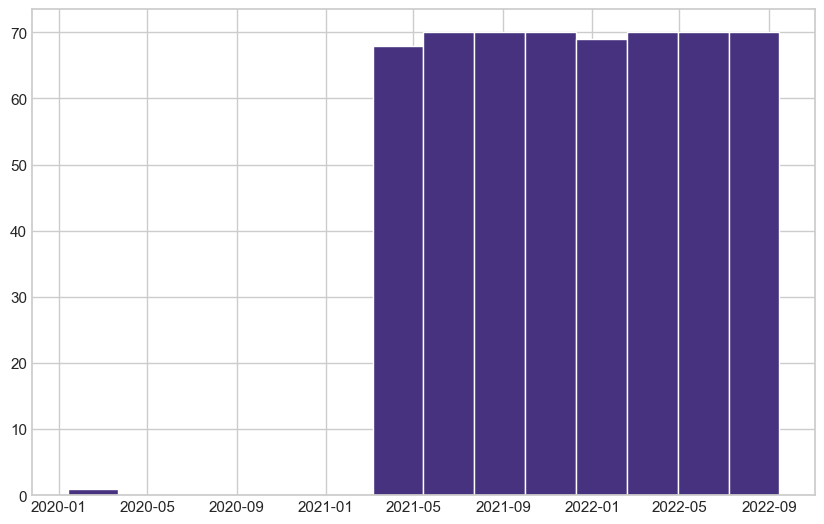

In [7]:
display(hospitalizations_df[hospitalizations_df.index < pd.to_datetime('2021-01-01')].isna().sum())

hospitalizations_df[hospitalizations_df.new_intensive_care_patients.isna()].reset_index().date.hist(bins=14)

new_hospitalized_patients               0
cumulative_hospitalized_patients        0
current_hospitalized_patients           0
new_intensive_care_patients           557
cumulative_intensive_care_patients    557
current_intensive_care_patients         0
new_ventilator_patients               557
cumulative_ventilator_patients        557
current_ventilator_patients           557
dtype: int64

<AxesSubplot: >

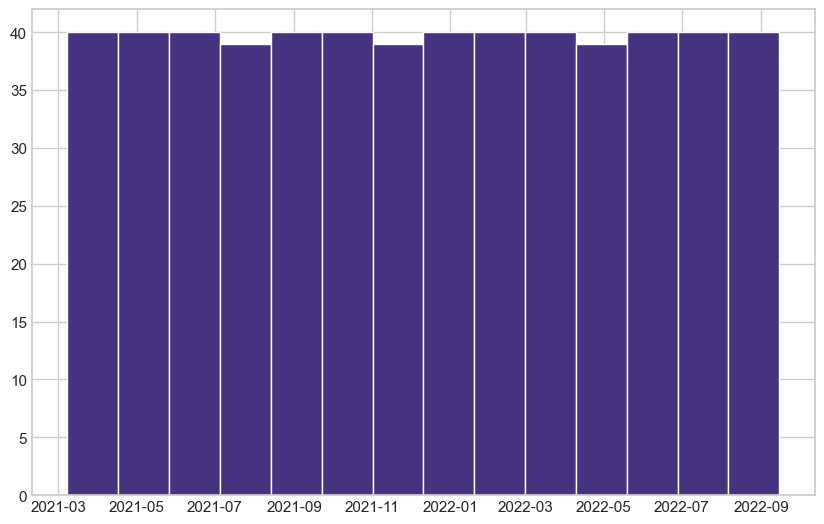

In [8]:
replace_nans_column = 'new_intensive_care_patients'

mask = (hospitalizations_df.index < pd.to_datetime('2021-01-01')) & (hospitalizations_df[replace_nans_column] != hospitalizations_df[replace_nans_column])
hospitalizations_df.loc[mask, replace_nans_column] = 0


replace_nans_column = 'new_ventilator_patients'

mask = (hospitalizations_df.index < pd.to_datetime('2021-01-01')) & (hospitalizations_df[replace_nans_column] != hospitalizations_df[replace_nans_column])
hospitalizations_df.loc[mask, replace_nans_column] = 0


display(hospitalizations_df[hospitalizations_df.index > pd.to_datetime('2021-01-01')].isna().sum())

hospitalizations_df[hospitalizations_df.new_intensive_care_patients.isna()].reset_index().date.hist(bins=14)

In [9]:
hospitalizations_df.corr().iloc[:,1].to_frame().style.background_gradient(cmap='coolwarm')

,cumulative_hospitalized_patients
new_hospitalized_patients,0.213848
cumulative_hospitalized_patients,1.000000
current_hospitalized_patients,0.063133
new_intensive_care_patients,0.258663
cumulative_intensive_care_patients,0.936255
current_intensive_care_patients,-0.096025
new_ventilator_patients,0.068149
cumulative_ventilator_patients,0.903757
current_ventilator_patients,0.605184


We are employing a strategy to impute missing values in our dataset, particularly for the variables 'ICU' and 'Ventilators'. This is achieved by leveraging the correlation between 'Hospitalizations' and these two variables, and by utilizing a simple linear regression model.

For the 'ICU' variable, the linear regression model is represented as:

$$ y = c + \beta \times x $$

where:

- $y$ represents the estimated ICU values.
- $x$ represents the 'Hospitalizations'. I subtracted the values of hospitalizations on the last day to set the value of x to 0.
- $\beta$ is calculated as the standard deviation ratio between 'Hospitalizations' and 'ICU', multiplied by the correlation strength between 'Hospitalizations' and 'ICU'. 
  - That is, $\beta = \frac{\sigma_{\text{Hospitalizations}}}{\sigma_{\text{ICU}}} \times r_{\text{Hospitalizations, ICU}}$.
- $c$ represents the last observed 'ICU' value.

For the 'Ventilators' variable, the linear regression model is represented as:

$$ y = c + \beta \times x $$

where:

- $y$ represents the estimated 'Ventilators' values.
- $x$ represents the 'Hospitalizations'. I subtracted the values of hospitalizations on the last day to set the value of x to 0.
- $\beta$ is calculated as the standard deviation ratio between 'Hospitalizations' and 'Ventilators', multiplied by the correlation strength between 'Hospitalizations' and 'Ventilators'. 
  - That is, $\beta = \frac{\sigma_{\text{Hospitalizations}}}{\sigma_{\text{Ventilators}}} \times r_{\text{Hospitalizations, Ventilators}}$.
- $c$ represents the last observed 'Ventilators' value.

These models provide a basis for filling in missing values based on the linear relationship between 'Hospitalizations' and the respective variables.

In [10]:
def estimate_missing_values_with_slr(df, target_col, predictor_col):
    # Find Beta0 
    last_date = df[target_col].idxmax()
    beta0 = df.loc[last_date, target_col]

    # Find x
    accum_predictor = df[predictor_col]
    last_predictor_value = df.loc[last_date, predictor_col]
    x = accum_predictor - last_predictor_value

    # Find Beta1
    corr_target = df.corr().iloc[:,1][target_col]
    beta1 = corr_target * df[target_col].std() / accum_predictor.std()

    # Linear Regression Equation
    predicted_target = beta0 + (beta1 * x)

    return predicted_target



# Single Linear Regression Equation Function and Predicted Values
predicted_vents = estimate_missing_values_with_slr(hospitalizations_df, 'cumulative_ventilator_patients', 'cumulative_hospitalized_patients')

predicted_icu = estimate_missing_values_with_slr(hospitalizations_df, 'cumulative_intensive_care_patients', 'cumulative_hospitalized_patients')


In [13]:
from sklearn.linear_model import LinearRegression

last_day = hospitalizations_df['cumulative_ventilator_patients'].idxmax()



# Define our features and target
features = hospitalizations_df.loc[hospitalizations_df.index < last_day, ['current_intensive_care_patients', 'new_hospitalized_patients', 'cumulative_hospitalized_patients', 'current_hospitalized_patients']]
target = hospitalizations_df.loc[hospitalizations_df.index < last_day, ['cumulative_intensive_care_patients', 'cumulative_ventilator_patients']]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Initialize the model
model = CatBoostRegressor()

# Fit the model on the training data
model.fit(X_train, y_train)

# Use the model to predict on the test data
y_pred = model.predict(X_test)

# Now y_pred contains the predicted values for 'cumulative_ventilator_patients' and 'cumulative_intensive_care_patients' 

model.score(X_test, y_test)

NameError: name 'CatBoostRegressor' is not defined

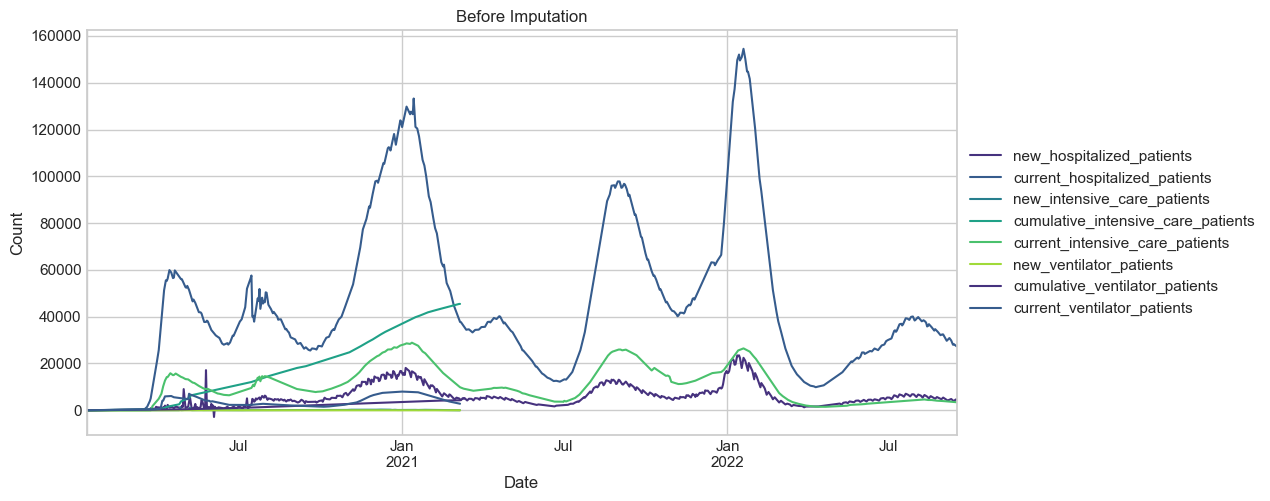

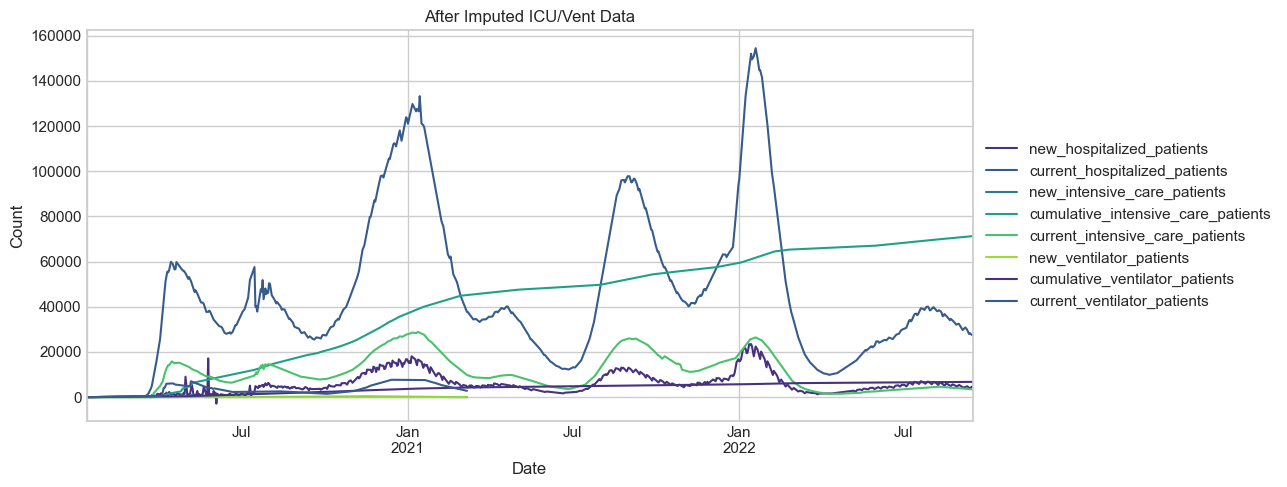

In [ ]:
# Plotting before imputation
ax_before = hospitalizations_df.drop(columns='cumulative_hospitalized_patients').plot(title='Before Imputation', figsize=(10,5))
ax_before.set_xlabel("Date")
ax_before.set_ylabel("Count")
ax_before.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Imputing missing values
hospitalizations_df['cumulative_ventilator_patients'] = hospitalizations_df['cumulative_ventilator_patients'].fillna(predicted_vents) 
hospitalizations_df['cumulative_intensive_care_patients'] = hospitalizations_df['cumulative_intensive_care_patients'].fillna(predicted_icu)

# Plotting after imputation
ax_after = hospitalizations_df.drop(columns='cumulative_hospitalized_patients').plot(title='After Imputed ICU/Vent Data', figsize=(13,5))
ax_after.set_xlabel("Date")
ax_after.set_ylabel("Count")
ax_after.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Adjust the layout
plt.tight_layout()
plt.show()


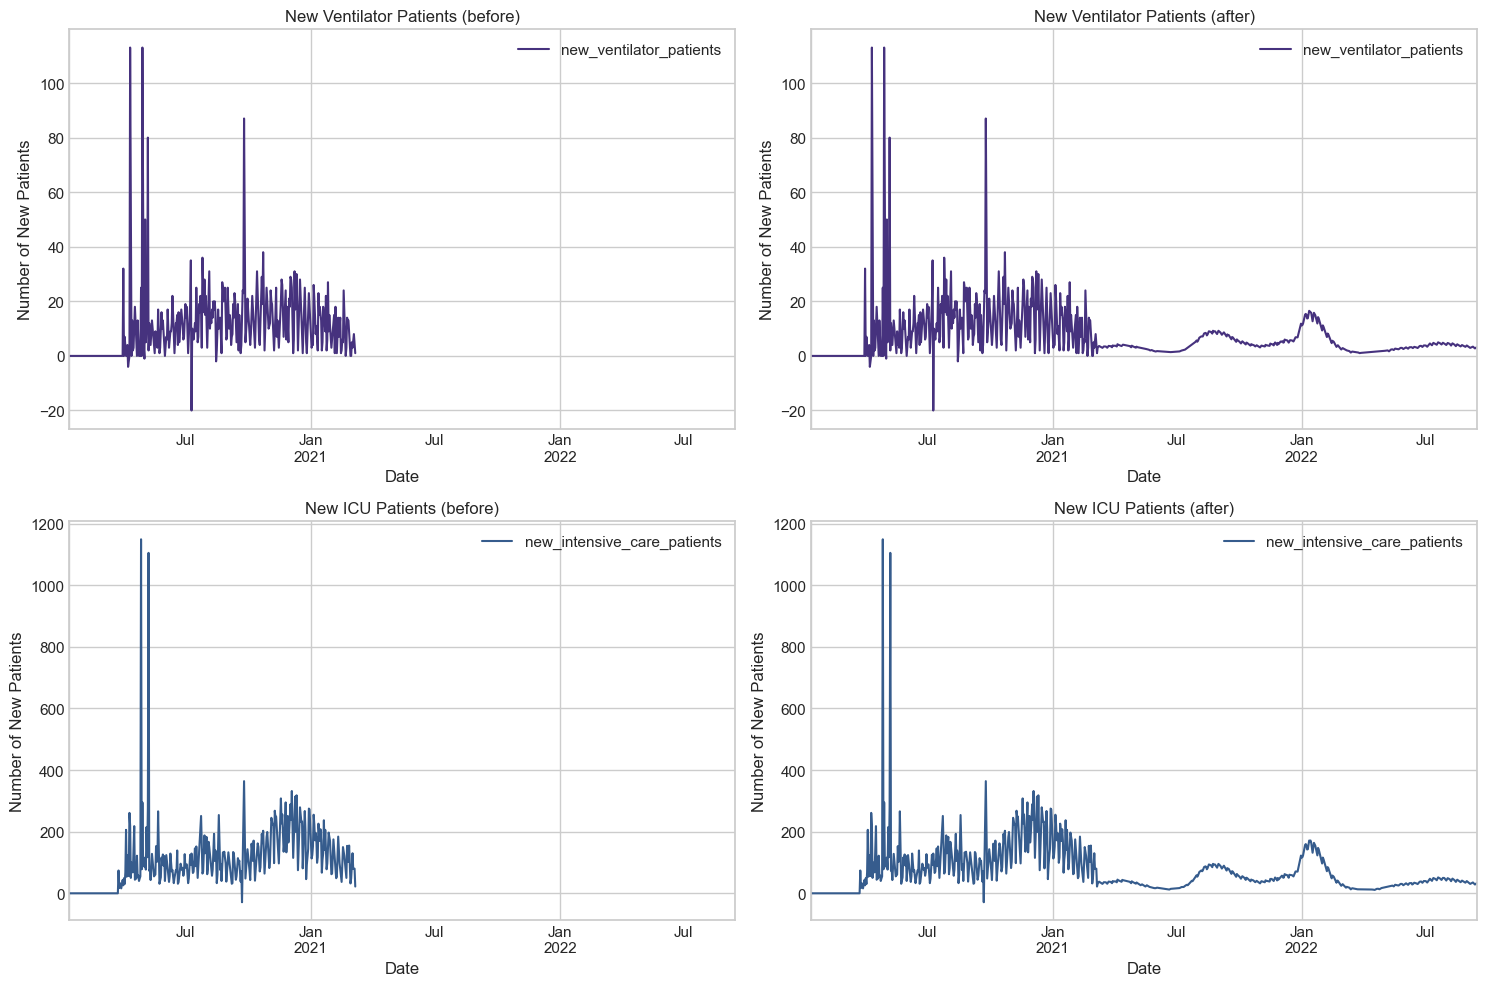

In [ ]:
# Creating a figure with two columns
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

# Plotting the "before" graphs
hospitalizations_df[['new_ventilator_patients', 'new_intensive_care_patients']].plot(subplots=True, ax=axes[:, 0])

# Updating data
daily_vents = hospitalizations_df['cumulative_ventilator_patients'].diff()
daily_icu = hospitalizations_df['cumulative_intensive_care_patients'].diff()

hospitalizations_df['new_ventilator_patients'] = hospitalizations_df['new_ventilator_patients'].fillna(daily_vents) 
hospitalizations_df['new_intensive_care_patients'] = hospitalizations_df['new_intensive_care_patients'].fillna(daily_icu)

# Plotting the "after" graphs
hospitalizations_df[['new_ventilator_patients', 'new_intensive_care_patients']].plot(subplots=True, ax=axes[:, 1])

# Adding titles to columns
axes[0, 0].set_title('New Ventilator Patients (before)')
axes[1, 0].set_title('New ICU Patients (before)')
axes[0, 1].set_title('New Ventilator Patients (after)')
axes[1, 1].set_title('New ICU Patients (after)')

# Adding labels to axes
for ax in axes.flatten():
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of New Patients')

plt.tight_layout()
plt.show()


In [ ]:
hospitalizations_df.corr().iloc[:,-1].to_frame().style.background_gradient(cmap='coolwarm')


,current_ventilator_patients
new_hospitalized_patients,0.766863
cumulative_hospitalized_patients,0.605184
current_hospitalized_patients,0.938405
new_intensive_care_patients,0.510835
cumulative_intensive_care_patients,0.630599
current_intensive_care_patients,0.933756
new_ventilator_patients,0.244868
cumulative_ventilator_patients,0.606195
current_ventilator_patients,1.000000


In [ ]:
# # Load the mobility data from the CSV file
mobility_df = pd.read_csv(f'{folder_holder}mobility.csv')


In [ ]:

# Clean the mobility data using the 'clean_df' function
mobility_df = clean_df(mobility_df, location_key)



<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 941 entries, 2020-02-15 to 2022-09-12
Data columns (total 6 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   mobility_retail_and_recreation  941 non-null    float64
 1   mobility_grocery_and_pharmacy   941 non-null    float64
 2   mobility_parks                  941 non-null    float64
 3   mobility_transit_stations       941 non-null    float64
 4   mobility_workplaces             941 non-null    float64
 5   mobility_residential            941 non-null    float64
dtypes: float64(6)
memory usage: 51.5 KB


,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
date,,,,,,
2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0


In [ ]:
mobility_df.isna().sum()

mobility_retail_and_recreation    0
mobility_grocery_and_pharmacy     0
mobility_parks                    0
mobility_transit_stations         0
mobility_workplaces               0
mobility_residential              0
dtype: int64

In [ ]:
display(mobility_df.agg(['min', 'max']))

mobility_df = mobility_df.applymap(lambda x: np.abs(x)).astype('int16')

display(mobility_df.applymap(lambda x: np.abs(x)).astype('int16').agg(['min', 'max']))

,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
min,-82.0,-61.0,-38.0,-67.0,-84.0,-2.0
max,14.0,36.0,127.0,7.0,5.0,27.0


,mobility_retail_and_recreation,mobility_grocery_and_pharmacy,mobility_parks,mobility_transit_stations,mobility_workplaces,mobility_residential
min,0,0,0,0,0,0
max,82,61,127,67,84,27


In [ ]:
ddddddddddd
# # Load the weather data from the CSV file
weather_df = pd.read_csv(f'{folder_holder}weather.csv')

# # Load the government response data from the CSV file
# gov_response_df = pd.read_csv(f'{folder_holder}oxford-government-response.csv')


NameError: name 'ddddddddddd' is not defined

In [ ]:

# Clean the weather data using the 'clean_df' function and fill any NA/NaN values with 0
weather_df = clean_df(weather_df, location_key).fillna(0)


NameError: name 'weather_df' is not defined

In [ ]:

# Clean the government response data using the 'clean_df' function
gov_response_df = clean_df(gov_response_df, location_key)


In [ ]:
# Calculate the number of common indices between the two dataframes.
len(disease_df.index) + len(gov_response_df.index) - len(disease_df.index.symmetric_difference(gov_response_df.index))


In [ ]:
# Identify columns common to 'disease_df' and 'gov_response_df'.
list_of_same_columns = disease_df.columns[disease_df.columns.isin(gov_response_df.columns)]

# Count duplicate rows when the common columns of the two dataframes are concatenated.
pd.concat([disease_df[list_of_same_columns], gov_response_df[list_of_same_columns]]).duplicated().sum()


In [ ]:
# Remove the common columns from 'gov_response_df'.
gov_response_df = gov_response_df.drop(columns = list_of_same_columns)


### Final Merging of Datasets

In [ ]:
# Create a list of dataframes to be merged
time_series_dfs = [disease_df, hospitalizations_df, mobility_df, gov_response_df, weather_df]

# Use functools.reduce to merge all dataframes in the list on 'date' column, with 'left' join method
master_df = reduce(lambda a, b: pd.merge(a, b, how='left', right_on='date', left_on='date'), time_series_dfs)

# Display summary and first few rows of the master dataframe
master_df.info()
master_df.head()


In [ ]:
"""
Cell generated by Data Wrangler.
"""
def clean_data(master_df):
    master_df = master_df.drop(columns=['country_united_states', 'product_0', 'product_johnson&johnson,_moderna,_novavax,_pfizer/biontech', 'fiscal_measures', 'international_support', 'investment_in_vaccines', 'emergency_investment_in_healthcare'])
    return master_df

master_df = clean_data(master_df.copy())
master_df.head()

In [ ]:
# master_df.to_parquet('../Data/master_df.parquet', compression='snappy')
master_df = pd.read_parquet('../Data/master_df.parquet')

dfSummary(master_df, is_collapsible=True)

# ***DATA LEAKAGE ALERT***

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# Initialize the imputer
imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=100, random_state=42))

# Fit the imputer on the dataframe and transform
df_imputed = imputer.fit_transform(hospitalizations_df)

# Convert back to pandas dataframe and assign column names
df_imputed = pd.DataFrame(df_imputed, columns=master_df.columns)

df_imputed


In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor

# Initialize the imputer
imputer = IterativeImputer(estimator=ExtraTreesRegressor(n_estimators=10, random_state=0))

# Fit the imputer on the dataframe and transform
df_imputed = imputer.fit_transform(master_df)

# Convert back to pandas dataframe and assign column names
df_imputed = pd.DataFrame(df_imputed, columns=master_df.columns)

df_imputed


In [ ]:
df_imputed.info()

### Extra Code

In [ ]:

# # Growth factor: (delta Number_n) / (delta Number_n)
# df = df.diff() / df.diff().shift(freq="D")

# # Rolling mean (window: 7 days)
# df = df.rolling(7).mean().dropna().loc[:covid_df["Date"].max(), :]
# numeric_columns_assessment(eng.all()).T

In [ ]:
# """
# Cell generated by Data Wrangler.
# """
# def clean_data(df):
#     # Filter rows based on column: 'location_key'
#     # df = df[df['location_key'].str.contains(r"^(US|CA|DE|GB|FR|JP|AU|BR|ZA|IN)$", na=False)]
#     df = df[df['location_key'].str.contains(r"^(US)$", na=False)] # only the us to start

#     # Change column type to datetime64[ns] for column: 'date'
#     try:
#         df = df.astype({'date': 'datetime64[ns]'})
#     except:
#         pass
#     # Change column type to category for column: 'location_key'
#     df = df.astype({'location_key': 'category'})
#     return df


# time_series_dfs = list(map(clean_data, timeland_df))

# # # Assume dfs is your list of dataframes
# time_series_dfs = reduce(lambda left,right: pd.merge(left,right,on=['location_key', 'date'], how='left'), time_series_dfs).copy()


In [ ]:
# time_series_dfs.to_parquet(f'{folder_holder}time_series_dfs.parquet.gzip', compression='gzip')

# time_series_dfs = pd.read_parquet(f'{folder_holder}time_series_dfs.parquet.gzip')

In [ ]:
# time_series_dfs_line_plot = time_series_dfs.dropna(subset='new_confirmed').copy()
# # sns.lineplot(data = time_series_dfs_line_plot, x = 'date', y = 'new_confirmed')

# time_series_dfs_line_plot.plot(x = 'date', y = 'new_confirmed', figsize = (15, 10))

# # add lines for each column
# fig = px.line(time_series_dfs_line_plot, x=air_traffic.index, y=air_traffic.columns,)

# # axis labels and title
# fig.update_layout(
#     yaxis_title="Passenger-miles (billions)", 
#     legend_title="", 
#     title="Daily air travel from 1979 to 2002"
# )

# # activate slider
# fig.update_xaxes(rangeslider_visible=True)

# fig.show()

In [ ]:
# folder_holder = "C://Users/Samsickle/Documents/BrainStation_Capstone/Data/"
# # C:\Users\Samsickle\Documents\BrainStation_Capstone\Data

# # # # time series data
# # hospitalizations_df = pd.read_csv(f'{folder_holder}hospitalizations.csv') # 2
# # mobility_df = pd.read_csv(f'{folder_holder}mobility.csv') # 4
# # gov_response_df = pd.read_csv(f'{folder_holder}oxford-government-response.csv') # 5
# # weather_df = pd.read_csv(f'{folder_holder}weather.csv') # 6

# epid_df = pd.read_csv(f'{folder_holder}epidemiology.csv') # 1
# # vac_df = pd.read_csv(f'{folder_holder}vaccinations.csv') # 3


In [ ]:
# epid_df.sample(5)

In [ ]:
# Performs a Fillna with FFill on the data set or a fillna with a 0 if there is no previous value
# Retrieves only the dates between '2020-01-01' and '2022-09-15'

# eng.clean(kinds=['resample', 'fillna'], date_range=('2020-01-03', '2022-09-15'))
# eng.all().query('ISO3 == @country_ISO3').isna().sum().sum()

# creates an engine with only USA data and with the desire date
# complement does three things, forces always increasing cumulate values, estimates recovered cases using value of estimated recovery period

# eng.subset(geo=country_ISO3, start_date='2020-01-03', end_date='2022-09-15', complement=True)
# eng.all().ISO3.unique(), eng.all().Date.min(), eng.all().Date.max()
# Uses the SIR model to estimate the number of infected and susceptible people

# main_variables = ['Infected', 'Susceptible']
# eng.transform()
# eng.all().query('ISO3 == @country_ISO3').info()
# eng.all().query('ISO3 == @country_ISO3')[main_variables].describe().T
# estimates the length of recovery and the length of the incubation period


# eng.clean()
# eng.transform()


# actual_df, status, _ = eng.subset(geo=country_ISO3, start_date='2020-01-03', end_date='2022-09-15', complement=True)
# print(status)
# actual_df.tail()



# with_df, status, status_dict = eng.subset(geo=@country_ISO3, start_date='2020-01-01', end_date='2022-09-15', complement=True)
# print(f"{status}\n")
# print(status_dict)
# with_df.info()
# with_df.head()


# """
# Cell generated by Data Wrangler.
# """
# def clean_data(with_df):
#     # Replace all instances of 0 with 0 in column: 'Positive_rate'
#     with_df.loc[with_df['Positive_rate'] != with_df['Positive_rate'], 'Positive_rate'] = 0
#     with_df.loc[with_df['Positive_rate'] == np.inf, 'Positive_rate'] = 0
#     return with_df

# with_df_clean = clean_data(with_df.copy())
# with_df_clean.head()
# cs.line_plot(with_df[["Confirmed", "Fatal", "Recovered"]], title="USA: records WITH complement")
# with_df.info()

# snr_act = cs.ODEScenario.auto_build(geo=country_ISO3, model=cs.SIRFModel, complement=True)

# snr_act.simulate(name="Baseline");
# dyn_act = snr_act.to_dynamics(name="Baseline")
# # Show summary
# display(dyn_act.summary())
# # Simulation
# dyn_act_df = dyn_act.simulate(model_specific=False)
# cs.line_plot(
#     dyn_act_df.drop("Susceptible", axis=1), "USA: Simulated data (Baseline scenario)")

Data Wireframe:

1. Date and Location:
    - 'date' - the day of the observations
    - 'location_key' - the country of the observations. I choose ten countries of interest in different regions

United States (US)  
Canada (CA)  
Germany (DE)  
United Kingdom (GB)  
France (FR)  
Japan (JP)  
Australia (AU)  
Brazil (BR)  
South Africa (ZA)  
India (IN)  
These countries are often used as indicators for their respective regions due to their significant economic influence, political stability, and comprehensive data collection practices.

2. COVID-19 Statistics:
    - 'new_confirmed' (New Positive Cases) - the number of new confirmed cases of COVID-19, this includes some negative numbers to account for data corrections in the previous days, however because these numbers are aggregated accross a whole country, the negative numbers are often very small and remain positive
    - 'new_deceased' (New Deaths) - the number of new deaths due to COVID-19 also shares the negative number problem
    - 'new_hospitalized_patients' (New Hospitalizations) 

3. Mobility Data:
    - 'mobility_retail_and_recreation'
    - 'mobility_grocery_and_pharmacy'
    - 'mobility_parks'
    - 'mobility_transit_stations'
    - 'mobility_workplaces'
    - 'mobility_residential'



4. Vaccination Data:
    - 'new_persons_vaccinated'
    - 'cumulative_persons_vaccinated'
    - 'new_persons_fully_vaccinated'
    - 'cumulative_persons_fully_vaccinated'
    - 'new_vaccine_doses_administered'
    - 'cumulative_vaccine_doses_administered'

5. Policy Measures:
    - 'school_closing'
    - 'workplace_closing'
    - 'cancel_public_events'
    - 'restrictions_on_gatherings'
    - 'public_transport_closing'
    - 'stay_at_home_requirements'
    - 'restrictions_on_internal_movement'
    - 'international_travel_controls'
    - 'income_support'
    - 'debt_relief'
    - 'fiscal_measures'
    - 'international_support'
    - 'public_information_campaigns'
    - 'testing_policy'
    - 'contact_tracing'
    - 'emergency_investment_in_healthcare'
    - 'investment_in_vaccines'
    - 'facial_coverings'
    - 'vaccination_policy'
    - 'stringency_index'

6. Weather Data:
    - 'average_temperature_celsius'
    - 'minimum_temperature_celsius'
    - 'maximum_temperature_celsius'
    - 'rainfall_mm'
    - 'snowfall_mm'
    - 'dew_point'
    - 'relative_humidity'


In [ ]:
# # location dfs
# geography_df = pd.read_csv(f'{folder_holder}geography.csv') #1
# health_df = pd.read_csv(f'{folder_holder}health.csv') #2
# demographics_df = pd.read_csv(f'{folder_holder}demographics.csv') #3
# economics_df = pd.read_csv(f'{folder_holder}economy.csv') #4


# locationland_df = [geography_df, health_df, demographics_df, economics_df]

In [ ]:
# location_df = list(map(clean_data, locationland_df))

# # Assume dfs is your list of dataframes
# location_df = reduce(lambda left,right: pd.merge(left,right,on='location_key', how='left'), location_df).copy()

# location_df.head()


In [ ]:

# location_df.to_pickle('../Data/location_df.pkl')
# location_df = pd.read_pickle('../Data/location_df.pkl')

# location_df.sample(3)

This dataframe provides a comprehensive snapshot of COVID-19 data, mobility metrics, government restrictions, and weather conditions for specific locations on specific dates. Here's a brief overview of the columns:

1. `Entry ID`: A unique identifier for each row in the dataframe.
2. `Date`: The date for the day on which the data was recorded.
3. `Location Key`: A code representing the location (10 different countries in total) for which the data is reported.

4. `New Confirmed`: The number of new confirmed COVID-19 cases on the given date.
5. `New Deceased`: The number of new COVID-19 related deaths on the given date.
6. `New Recovered`: The number of new recoveries from COVID-19 on the given date.
7. `New Tested`: The number of new COVID-19 tests conducted on the given date.

8. `New Hospitalizations`: The number of new hospitalizations due to COVID-19 on the given date.
9. `Current Hospitalizations`: The total number of current hospitalizations due to COVID-19 on the given date.

10. `New Fully Vaccinated (29+ other Vaccination Columns)`: The number of new fully vaccinated individuals on the given date. There are 29 other columns related to vaccination data here too.

11. `Retail and Recreation Mobility (5+ other Mobility Metrics)`: A measure of mobility in retail and recreation spaces, along with 5 other columns related to different aspects of mobility.

12. `School Closing (19+ other Government Restrictions)`: A measure indicating whether schools were closed on the given date, along with 19 other columns related to different government restrictions.

13. `Average Temp (6+ Other Weather Columns)`: The average temperature on the given date, along with 6 other columns related to different weather conditions.

In total there are 9880 and 82 rows for 6.3mbs of data. The main way I could increase or decrease the size of the dataset would be to include more countries, regions, or counties in the analysis. For now this is my starter df.
